In [23]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils import data as data_utils
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

In [24]:
# Read data 
df = pd.read_csv('/home/stefan/stef/Disk/Projects/SkillTask2/data/train.csv/train.csv')


In [25]:
# Create copy of a dataframe
data = df.copy()

In [26]:
data.head()

,sample_id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f1603,f1604,f1605,f1606,f1607,f1608,f1609,f1610,f1611,y
0,sample_0,25.609375,6.703125,3.652344,10.039062,169.375,102.8125,1.422852,6.722656,8.015625,...,8.070312,4.363281,5.019531,5.710938,6.343750,6.843750,7.289062,7.617188,7.980469,1.0
1,sample_1,18.343750,5.824219,2.966797,4.902344,164.625,71.8125,1.357422,5.894531,2.753906,...,7.359375,4.195312,4.808594,5.425781,5.949219,6.339844,6.730469,7.074219,7.175781,1.0
2,sample_2,28.562500,6.230469,3.583984,7.882812,159.500,113.1875,1.696289,6.316406,4.605469,...,8.562500,4.523438,5.097656,5.789062,6.457031,6.871094,7.386719,7.878906,8.328125,1.0
3,sample_3,28.062500,6.132812,2.726562,6.378906,169.750,111.0000,1.535156,6.199219,3.712891,...,4.558594,3.533203,3.900391,4.261719,4.042969,3.869141,3.890625,4.042969,4.273438,1.0
4,sample_4,20.109375,6.144531,3.203125,6.035156,164.750,78.8750,1.281250,6.187500,4.003906,...,6.613281,4.625000,4.996094,5.328125,5.593750,5.800781,6.027344,6.242188,6.449219,0.0


In [27]:
# Replace inf values with np.nan, then replace nan with 0
data.replace([np.inf, -np.inf], np.nan,inplace=True)
data = data.fillna(0)

In [28]:
# Features
X = data.drop(['sample_id', 'y'], axis=1)
# Labels
y = data['y']

In [29]:
# Features normalization
features_norm = StandardScaler() 
X_std = features_norm.fit_transform(X) 


In [30]:
# Split data in train/test
X_train, x_test, Y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

In [31]:
# To torch tensor: Train
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
Y_train_tensor = torch.tensor(Y_train.values).flatten() 

# Test
x_test_tensor = torch.tensor(x_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values).flatten() 

In [48]:
# Create train dataloader
batch_size = 128

train_dataset = data_utils.TensorDataset(X_train_tensor, Y_train_tensor) 
train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

# Create eval dataloader

eval_dataset = data_utils.TensorDataset(x_test_tensor, y_test_tensor) 
eval_loader = data_utils.DataLoader(dataset = eval_dataset, batch_size = batch_size, shuffle = True)

In [49]:
# Check batch sizes
for data, labels in eval_loader:
    print(data.size())
    print(labels.size())
    break

torch.Size([128, 1612])
torch.Size([128])


In [50]:
len(eval_loader)

2

In [239]:
# Class must extend nn.Module
class MyClassifier(nn.Module):
    def __init__(self):
        super(MyClassifier,self).__init__()
        # Our network consists of 3 layers. 1 input, 1 hidden and 1 output layer
         
        self.fc1 = nn.Linear(1612,200)
        self.fc2 = nn.Linear(200,100)
        self.layer_out = nn.Linear(100,1)
        
        self.dropout = nn.Dropout()
        
        
        
        self.bn0 = nn.BatchNorm1d(1612)
        self.bn1 = nn.BatchNorm1d(200)
        
        self.bn_out = nn.BatchNorm1d(100)
        
        
        
    
    def forward(self,x):
        
        # Batch normalization
        x = self.bn0(x)
        
        # This applies Linear transformation to input data with non-linear activation
        x = F.relu(self.fc1(x))
        
        # Dropout
        x = self.dropout(x) 
        
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x) 
        
        
        x = self.bn_out(x)
        #This applies linear transformation to produce output data
        x = self.layer_out(x)
        
        return x
        
    #This function takes an input and predicts the class, (0 or 1)        
    def predict(self, x):
        with torch.no_grad():
            y_pred = model(x)
            y_pred_tag = torch.round(torch.sigmoid(y_pred))
        return torch.tensor(y_pred_tag, dtype=float)
    
    
    def predict_proba(self, x):
        with torch.no_grad():
            y_pred = model(x)
            prob = torch.sigmoid(y_pred)
            

    
        return torch.tensor(prob, dtype=float)

In [240]:
# Initialize the model        
model = MyClassifier()
# Define loss criterion
criterion = nn.BCEWithLogitsLoss()
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [241]:
model

MyClassifier(
  (fc1): Linear(in_features=1612, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (layer_out): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (bn0): BatchNorm1d(1612, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_out): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [242]:
def train_model(model, optim, criterion, train_dl):
    model.train()
    total = 0
    sum_loss = 0
    for x, y in train_dl:
        batch = y.shape[0]
        output = model(x)   
        loss = criterion(output, y.unsqueeze(1))   
        optim.zero_grad()
        loss.backward()
        
        # Clip gradient 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optim.step()
        
        # Accumulate epoch loss 
        total += batch
        sum_loss += batch*(loss.item())
        # print("Batch loss: ", batch*(loss.item()))
    return sum_loss/total

In [243]:
def eval_model(model, criterion, eval_dl):
    model.eval()
    total = 0
    sum_loss = 0
    with torch.no_grad():
        for x, y in eval_dl:
            batch = y.shape[0]
            output = model(x)
            # output = F.softmax(output, dim=0)       
            loss = criterion(output, y.unsqueeze(1))   
            total += batch
            sum_loss += batch*(loss.item())
            
    return sum_loss/total

### Train model

In [244]:
#Number of epochs
epochs = 150
#List to store losses
train_losses = []
for i in range(epochs):
    epoch_loss = train_model(model=model, optim=optimizer, criterion=criterion, train_dl=train_loader)
    train_losses.append(epoch_loss)
    if i % 10 == 0:
        print("Epoch {0}, Loss {1}".format(i+1, epoch_loss))

Epoch 1, Loss 0.6545412898399616
Epoch 11, Loss 0.3396159158944234
Epoch 21, Loss 0.19234391044421517
Epoch 31, Loss 0.15131030069609588
Epoch 41, Loss 0.12801907668183274
Epoch 51, Loss 0.10352332134838563
Epoch 61, Loss 0.09885705549252302
Epoch 71, Loss 0.08237762341991518
Epoch 81, Loss 0.08116676670810559
Epoch 91, Loss 0.08008589576548235
Epoch 101, Loss 0.06066775889560976
Epoch 111, Loss 0.05213499500694568
Epoch 121, Loss 0.05721921429410863
Epoch 131, Loss 0.04538715899684873
Epoch 141, Loss 0.04919797582681674


### Evaluate model

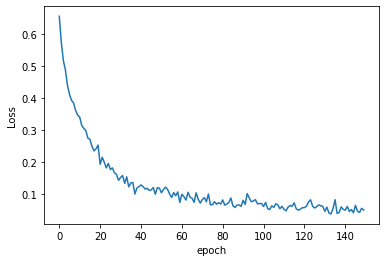

In [245]:
plt.plot(range(epochs), train_losses, label='Train loss')
plt.ylabel('Loss')
plt.xlabel('epoch');

In [247]:
roc_auc_score(y_test_tensor.long(), model.predict_proba(x_test_tensor))

<ipython-input-239-6751099eb6b7>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(prob, dtype=float)


0.8719957272565427

In [248]:
prob_voting = model.predict_proba(x_test_tensor)

<ipython-input-239-6751099eb6b7>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(prob, dtype=float)


In [249]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_tensor.numpy(), prob_voting.numpy())
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.874087591240876

Text(0.5, 0, 'False Positive Rate')

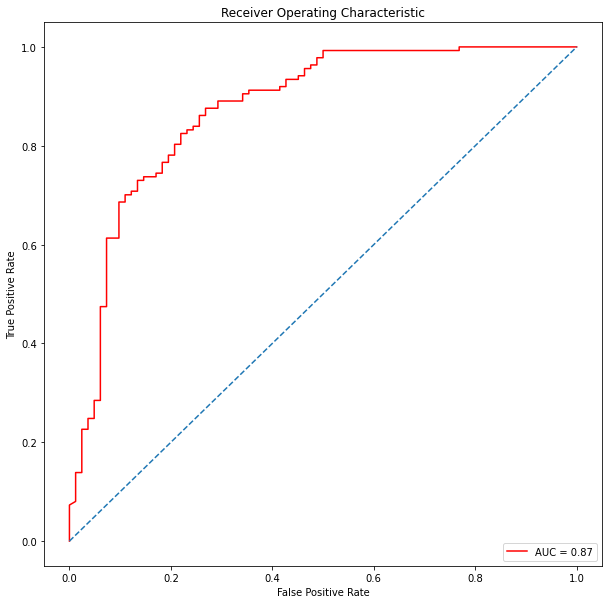

In [250]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

### Submission

In [165]:
df_test = pd.read_csv('/home/stefan/stef/Disk/Projects/SkillTask2/data/test.csv/test.csv')


In [166]:
# Replace inf values with np.nan, then replace nan with 0
df_test.replace([np.inf, -np.inf], np.nan,inplace=True)
df_test = df_test.fillna(0) 

# Features
X_submission = df_test.drop(['sample_id'], axis=1)

X_submission_std = features_norm.fit_transform(X_submission) 

In [167]:
X_submission_tensor = torch.tensor(X_submission_std, dtype=torch.float)

In [171]:
a = model.predict_proba(X_submission_tensor).numpy()

<ipython-input-153-700465339cf8>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(prob, dtype=float)


In [181]:
submission = pd.DataFrame(df_test["sample_id"], index=None)
submission["y"] = a
submission.to_csv("submission.csv", sep=",", index=False)

In [183]:
p = pd.read_csv("submission.csv")

,sample_id,y
0,sample_1095,1.533260e-05
1,sample_1096,9.999985e-01
2,sample_1097,2.504366e-02
3,sample_1098,9.294887e-01
4,sample_1099,5.174844e-07
